In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Setup the initial value of states

In [2]:
initialStates = np.zeros(7)
initialStates[1:6] = 0.5
initialStates[6] = 1

In [3]:
initialStates

array([ 0. ,  0.5,  0.5,  0.5,  0.5,  0.5,  1. ])

# Setup the true value of states

In [4]:
trueValue = np.zeros(7)
trueValue[1:6] = np.arange(1, 6) / 6.0
trueValue[6] = 1

# Setup random walk actions

In [5]:
GO_LEFT = 0
GO_RIGHT = 1

# Load training sets

In [8]:
trainingSets_array = np.load("trainingSets_array.npy")

# Define TD function learning from single random walk trajectory (no batch)

In [9]:
def TDFromSequence(trajectory, numStates, weights, LAMBDA, ALPHA):
    
    weightsChange = np.zeros(numStates)
    error_last = np.zeros(numStates)
    
    for i in range(len(trajectory) - 1): # skip the absorbing state
        
        state_current = trajectory[i]
        state_next = trajectory[i+1]
        
        #if ALPHA > 0.58:
        
        P_next = 0.0
        x_current = np.zeros(numStates)
        x_current[state_current-1] = 1.0
        P_current = weights[state_current-1]
        
        if (state_next == 0):
            P_next = 0.0
        elif (state_next == 6):
            P_next = 1.0
        else:
            x_next = np.zeros(numStates)
            x_next[state_next-1] = 1.0
            P_next = weights[state_next-1]
            
        # Calculating weights change, using eq(4) in Sutton 1988's article
        
        diff_P = P_next - P_current
        error_t = np.zeros(numStates)
        
        error_t = LAMBDA * error_last + x_current
        weightsChange = weightsChange + ALPHA * diff_P * error_t
        error_last = error_t
        
    return weightsChange

# Define TD function learning from a traing set (with batch)

In [10]:
def TDFromTrainingSet(trainingSet, numStates, weights, LAMBDA, ALPHA):
    
    weightsChange = np.zeros(numStates)
    
    for i in range(len(trainingSet)):
        
        episode = trainingSet[i]
        new_weightsChange = TDFromSequence(episode, numStates, weights, LAMBDA, ALPHA)
        weightsChange = weightsChange + new_weightsChange
    
    weightsChange = weightsChange / float(len(trainingSet))
    
    return weightsChange

# Define Root Mean Square Error (RMSE) function

In [11]:
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Function of computing RMSE for figure 3 in Sutton 1988's article

In [12]:
def generatingDataFigure3(trainingSets, LAMBDA):
    
    nstates = 5
    delta_w = np.zeros(nstates)
    
    alpha = 0.05
    RMSE_list = []
    epsilon = 0.0001
    
    for n in range(len(trainingSets)):
        
        trainingSet = trainingSets[n]
        IS_NOT_CONVERGED = True
        w = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
        
        while(IS_NOT_CONVERGED):
            
            old_w = w
            delta_w = TDFromTrainingSet(trainingSet, nstates, w, LAMBDA, alpha)
            w = w + delta_w

            if ( RMSE(old_w, w) < epsilon ):
                IS_NOT_CONVERGED = False
        
        predict_states = np.zeros(7)
        predict_states[1:6] = w
        predict_states[0] = 0.0
        predict_states[6] = 1.0
        target_states = trueValue
        RMSE_list.append( RMSE(predict_states, target_states) )
    
    meanRMSE = sum(RMSE_list) / float(len(RMSE_list))
    
    return meanRMSE  

# Generate RMSE values for figure 3 in Sutton 1988's article

In [17]:
def rmseFigure3(trainingSets):
    
    LAMBDAS = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
    rmse_Figure3 = []
    
    for LAMBDA in LAMBDAS:
        rmse_Figure3.append(generatingDataFigure3(trainingSets, LAMBDA))
        print(LAMBDA)
        print(rmse_Figure3)
    
    return rmse_Figure3

rmse_for_plotting_Fig3 = rmseFigure3(trainingSets_array)

0.0
[0.098542573815301931]
0.1
[0.098542573815301931, 0.098818492801862265]
0.3
[0.098542573815301931, 0.098818492801862265, 0.099974667977078865]
0.5
[0.098542573815301931, 0.098818492801862265, 0.099974667977078865, 0.10205426328379014]
0.7
[0.098542573815301931, 0.098818492801862265, 0.099974667977078865, 0.10205426328379014, 0.10597515309013593]
0.9
[0.098542573815301931, 0.098818492801862265, 0.099974667977078865, 0.10205426328379014, 0.10597515309013593, 0.1186078317745617]
1.0
[0.098542573815301931, 0.098818492801862265, 0.099974667977078865, 0.10205426328379014, 0.10597515309013593, 0.1186078317745617, 0.14152658378679123]


# Function of computing RMSE for figure 4 in Sutton 1988's article

In [13]:
def generatingDataFigure4(trainingSets, LAMBDA, ALPHA):
    
    nstates = 5
    delta_w = np.zeros(nstates)
    RMSE_list = []
    
    for n in range(len(trainingSets)):
        
        trainingSet = trainingSets[n]
        
        for m in range(len(trainingSet)):
            
            input_w = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
            
              
            delta_w = TDFromSequence(trainingSet[m], nstates, input_w, LAMBDA, ALPHA)
            w = input_w + delta_w
            
            
            predict_states = np.zeros(7)
            predict_states[1:6] = w
            predict_states[0] = 0.0
            predict_states[6] = 1.0
            target_states = trueValue
            RMSE_list.append( RMSE(predict_states, target_states) )
    
    meanRMSE = sum(RMSE_list) / float(len(RMSE_list))
    
    return meanRMSE 

# Generate RMSE values for figure 4 in Sutton 1988's article

In [15]:
def rmseFigure4(trainingSets):
    
    LAMBDAS = np.array(range(0,101,10))/100.00
    ALPHAS = np.array(range(0,61,5))/100.00
    rmse_Figure4 = {}
    
    for LAMBDA in LAMBDAS:
        
        ALPHAS_hash = {}
        
        for ALPHA in ALPHAS:
            ALPHAS_hash[ALPHA] = generatingDataFigure4(trainingSets, LAMBDA, ALPHA)
        #print(LAMBDA)
        #print(ALPHAS_hash)
        
        rmse_Figure4[LAMBDA] = ALPHAS_hash
        
    return rmse_Figure4

rmse_for_plotting_Fig4 = rmseFigure4(trainingSets_array)

# Plotting Figure 3 in in Sutton 1988's article

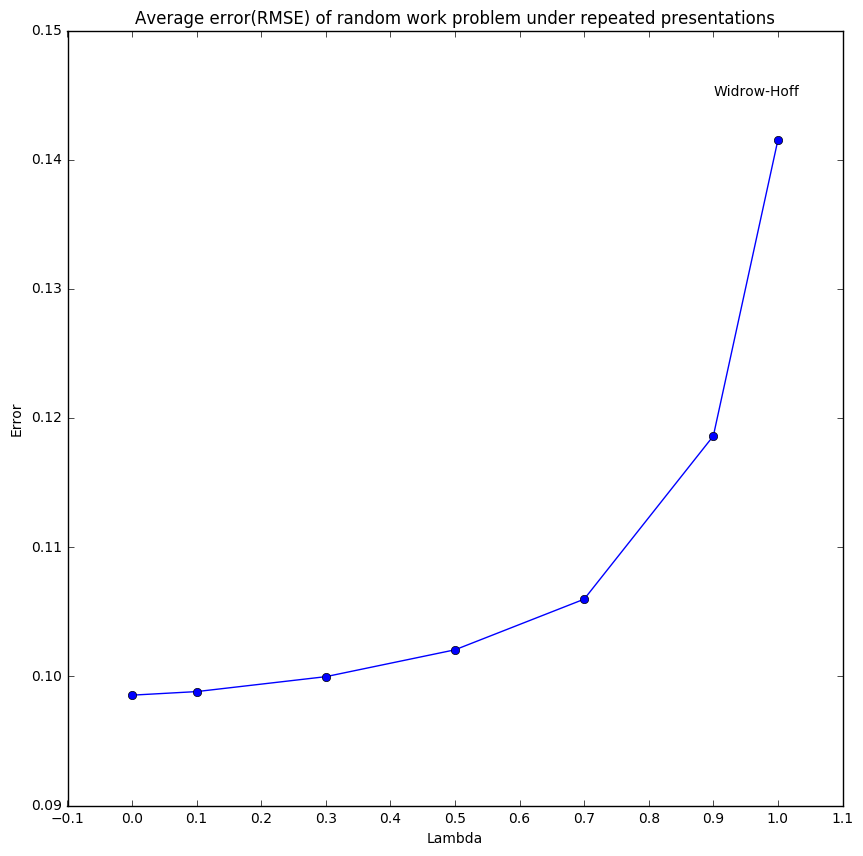

In [36]:
plt.figure(figsize=(10,10))
LAMBDAS = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
plt.plot(LAMBDAS, rmse_for_plotting_Fig3, 'o-')

plt.yticks(np.linspace(0.09,0.15,7,endpoint=True))
plt.xticks(np.linspace(-0.1,1.1,13,endpoint=True))

plt.ylabel('Error')
plt.xlabel('Lambda')
plt.title('Average error(RMSE) of random work problem under repeated presentations')

plt.text(0.9, 0.145, 'Widrow-Hoff')

plt.show()

# Plotting Figure 4 in in Sutton 1988's article

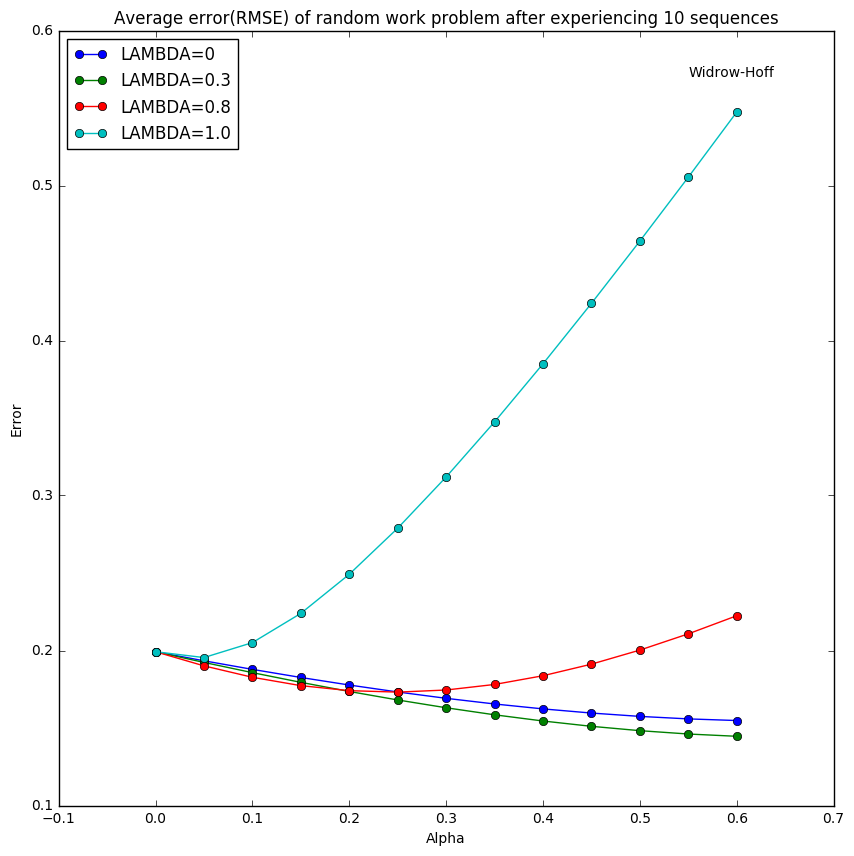

In [82]:
ALPHAS = np.array(range(0,61,5))/100.00
LAMBDAS = sorted(rmse_for_plotting_Fig4.iterkeys())

l1 = []
for key in sorted(rmse_for_plotting_Fig4[LAMBDAS[0]].iterkeys()):
    l1.append(rmse_for_plotting_Fig4[LAMBDAS[0]][key])

l2 = []
for key in sorted(rmse_for_plotting_Fig4[LAMBDAS[3]].iterkeys()):
    l2.append(rmse_for_plotting_Fig4[LAMBDAS[3]][key])

l3 = []
for key in sorted(rmse_for_plotting_Fig4[LAMBDAS[8]].iterkeys()):
    l3.append(rmse_for_plotting_Fig4[LAMBDAS[8]][key])

l4 = []
for key in sorted(rmse_for_plotting_Fig4[LAMBDAS[10]].iterkeys()):
    l4.append(rmse_for_plotting_Fig4[LAMBDAS[10]][key])

plt.figure(figsize=(10,10))


plt.plot(ALPHAS, l1, 'o-')
plt.plot(ALPHAS, l2, 'o-')
plt.plot(ALPHAS, l3, 'o-')
plt.plot(ALPHAS, l4, 'o-')

plt.yticks(np.linspace(0.1,0.6,6,endpoint=True))
plt.xticks(np.linspace(-0.1,0.7,9,endpoint=True))

plt.ylabel('Error')
plt.xlabel('Alpha')
plt.title('Average error(RMSE) of random work problem after experiencing 10 sequences')
plt.text(0.55, 0.57, 'Widrow-Hoff')

plt.legend(['LAMBDA=0', 'LAMBDA=0.3', 'LAMBDA=0.8', 'LAMBDA=1.0'], loc='upper left')
plt.show()


# Plotting Figure 5 in in Sutton 1988's article

0.6 0.154816840067
0.6 0.150533917453
0.6 0.147019235831
0.6 0.144646239799
0.6 0.144214751294
0.55 0.147147958908
0.5 0.153368355991
0.35 0.16223186488
0.25 0.17315355386
0.15 0.185212735048
0.05 0.195441544428


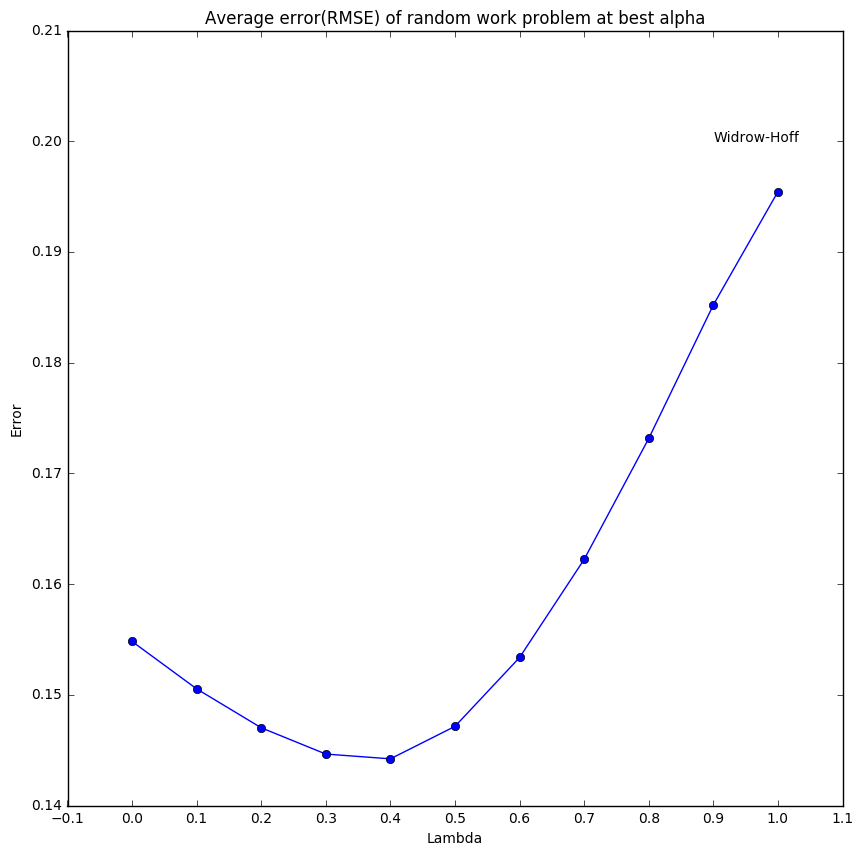

In [90]:
LAMBDAS = sorted(rmse_for_plotting_Fig4.iterkeys())
minRMSE = []

for LAMBDA in LAMBDAS:
    
    minAlpha = min(rmse_for_plotting_Fig4[LAMBDA], key=rmse_for_plotting_Fig4[LAMBDA].get)
    minError = rmse_for_plotting_Fig4[LAMBDA][minAlpha]
    
    print(minAlpha, minError)
    
    minRMSE.append(minError)

plt.figure(figsize=(10,10))
plt.plot(LAMBDAS, minRMSE, 'o-')

plt.yticks(np.linspace(0.14,0.21,8,endpoint=True))
plt.xticks(np.linspace(-0.1,1.1,13,endpoint=True))

plt.ylabel('Error')
plt.xlabel('Lambda')
plt.title('Average error(RMSE) of random work problem at best alpha')

plt.text(0.9, 0.2, 'Widrow-Hoff')

plt.show()